In [1]:
import numpy as np

import lapgm
import view_utils
import brainweb_utils

# Data Acquisition
We will be using a variant of the *BrainWeb* dataset for our debiasing example. Example data will be downloaded once into the examples/data subfolder.

In [2]:
# Download and read BrainWeb normal data
brainweb_dict = brainweb_utils.get_biased_data()

brainweb_data = [brainweb_dict['T1'], brainweb_dict['T2'], brainweb_dict['PD']]

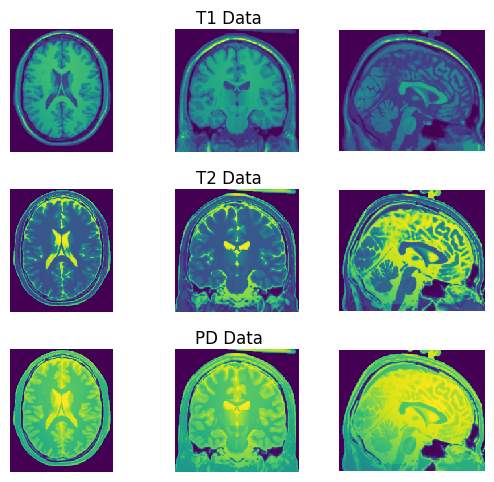

In [3]:
# Associated label data
class_data = brainweb_utils.download_and_read_phantom()
data_mask = class_data > 0

# View center slices of the BrainWeb dataset
view_utils.view_center_slices(brainweb_data, data_mask, ['T1 Data', 'T2 Data', 'PD Data'])

# Debias Setup and Run
LapGM can be run either on the CPU or GPU if appropriate packages are installed. Next cell specifies whether GPU compute should be used.

In [4]:
# Skip or comment out if GPU is not available
lapgm.use_gpu(True)

Next we set up the LapGM object by specifying settings and hyperparameters for the run.

In [5]:
# Computation can be saved by specifying a downscaling factor.
debias_obj = lapgm.LapGM(downscale_factor=2)

# -- Specify hyperparameters --
# tau is a gradient scale penalty on the bias estimation
# n_classes specifies the number of tissue classes visible (including ambient space)
# log_initialize initializes clusters with log transform. Increases sensitivity to finding clusters
#     of similar intensity. For less dispersed bias fields it may be better to set to true.
debias_obj.set_hyperparameters(tau=1e-5, n_classes=6, log_initialize=False)

# Cast datatype and attach relevant sequence information
brainweb_arr = lapgm.to_sequence_array([brainweb_dict['T1'], brainweb_dict['T2'], brainweb_dict['PD']])

In [6]:
# Run debias procedure and take parameter output
params = debias_obj.estimate_parameters(brainweb_arr, print_tols=True)

iter: 0, Bdiff: inf
iter: 1, Bdiff: 0.29737375878129196
iter: 2, Bdiff: 0.32186811438189594
iter: 3, Bdiff: 0.13219592764815183
iter: 4, Bdiff: 0.01628123628382528
iter: 5, Bdiff: 0.03017076901865424
iter: 6, Bdiff: 0.006458747596052669
iter: 7, Bdiff: 0.008242992346942878
iter: 8, Bdiff: 0.00710618775457163
iter: 9, Bdiff: 0.006650973406444835
iter: 10, Bdiff: 0.012823954871922947
iter: 11, Bdiff: 0.005959108548661112
iter: 12, Bdiff: 0.016335133952836325
iter: 13, Bdiff: 0.006703936974535853
iter: 14, Bdiff: 0.007740826240558824
iter: 15, Bdiff: 0.017308436779930325
iter: 16, Bdiff: 0.01151896764445058
iter: 17, Bdiff: 0.019281885266924304
iter: 18, Bdiff: 0.01689478977232264
iter: 19, Bdiff: 0.01385703321510572
iter: 20, Bdiff: 0.006933534823281303
iter: 21, Bdiff: 0.01714736052679339
iter: 22, Bdiff: 0.008597556227216837
iter: 23, Bdiff: 0.005914508417843063
iter: 24, Bdiff: 0.02022230635233918


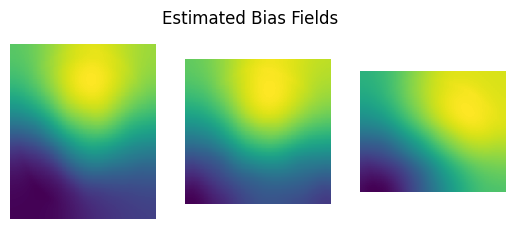

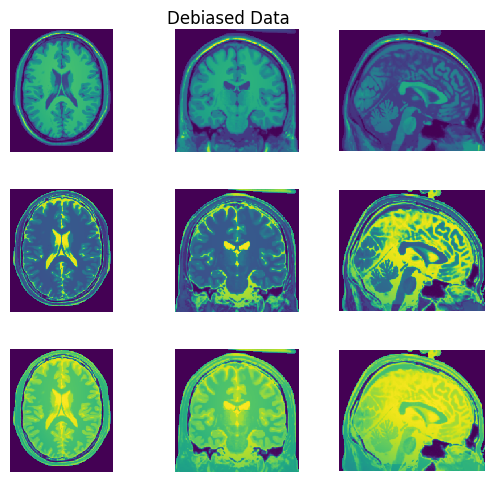

In [7]:
view_utils.view_center_slices(np.exp(params.B), title_names=['Estimated Bias Fields'])

brainweb_deb = lapgm.debias(brainweb_arr, params)
view_utils.view_center_slices(brainweb_deb, data_mask, ['Debiased Data', None, None])

A total of six classes were used in estimation while ten are provided in the ground truth phantom. 

As the number of classes increases, estimation becomes more difficult. This can be mitigated by estimated clases on the non-downsample data (with tau value adjusted accordingly).

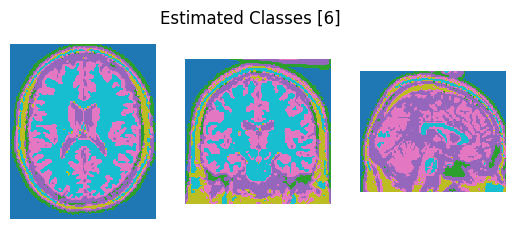

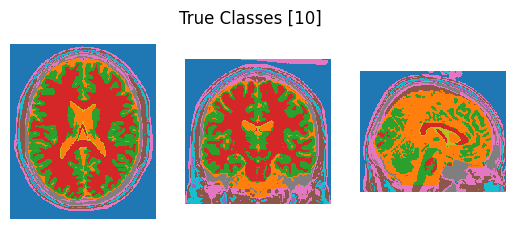

In [8]:
# 
view_utils.view_class_map(params.w, order=np.argsort(params.mu[:,0]), title_name='Estimated Classes [6]')
view_utils.view_center_slices(class_data, cmap_name='tab10', title_names=['True Classes [10]'])